# Data Science project: OpenVaccine
**Name: Carson Wilde**

**A-Number: A02224905**

**https://www.kaggle.com/c/stanford-covid-vaccine**


# Environment Setup

1.   Imports
2.   Mount Drive
3.   Load Data





In [1]:
### import statements
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda")

In [2]:
### load data and mount drive if needed
from google.colab import drive
drive.mount('/content/drive')
home_path = '/content/drive/My Drive/Colab Notebooks/data_science_project'

bpps_path = home_path + '/data/bpps/'
train_data_file = home_path + '/data/train.json'
test_data_file = home_path + '/data/test.json'
sample_submission_file = home_path + '/data/sample_submission.csv'
submission_file = home_path + '/my_submission.csv'

Mounted at /content/drive


In [3]:
### define dataset classes
class TrainDataset(Dataset):
  def __init__(self, df):# ids, train_features, train_labels):
    super().__init__()
    self.ids = self.extract_info(df)
    self.train_features = self.extract_features(df)
    self.train_labels = self.extract_labels(df)
    # self.ids = ids
    # self.train_features = train_features
    # self.train_labels = train_labels

  def __len__(self):
    return len(self.train_features)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    return self.ids[idx], self.train_features[idx], self.train_labels[idx]
  
  def extract_info(self, df):
    res = []
    for i, r in df.iterrows():
      if r['SN_filter'] != 1:
        continue
      res.append(r['id'])
    return np.array(res)

  def extract_features(self, df):
    res = []
    a = "AGUC(.)SMIBHEX"
    d = dict((c, i) for i, c in enumerate(a))
    data = df[['sequence', 'structure', 'predicted_loop_type']]
    for i in range(len(data['sequence'])):
      if df['SN_filter'][i] != 1:
        continue
      re = []
      for j in range(df['seq_scored'][i]):
        r = np.zeros(14, dtype=float)
        for k in data.columns:
          r[d[ data[k][i] [j]]] = 1
        re.append(r)
      res.append(np.array(re, dtype=float))
    return np.array(res, dtype=float)

  def extract_labels(self, df): #reactivity, deg_Mg_pH10, deg_pH10, deg_Mg_50C, deg_50C):
    data = df[['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
    res = []
    for i in range(len(data['reactivity'])):
      if df['SN_filter'][i] != 1:
        continue
      re = []
      for j in range(len(data['reactivity'][i])):
        r = []
        for k in data.columns:
          r.append(data[k][i][j])
        re.append(np.array(r))
      res.append(np.array(re))
    return np.array(res)


class TestDataset(Dataset):
  def __init__(self, df): #ids, features):
    super().__init__()
    self.ids = self.extract_info(df)
    self.features = self.extract_features(df)
    # self.ids = ids
    # self.features = features

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    return self.ids[idx], self.features[idx]

  def extract_info(self, df):
    res = []
    for i, r in df.iterrows():
      res.append(r['id'])
    return np.array(res)

  def extract_features(self, df):
    res = []
    a = "AGUC(.)SMIBHEX"
    d = dict((c, i) for i, c in enumerate(a))
    data = df[['sequence', 'structure', 'predicted_loop_type']]
    for i in range(len(data['sequence'])):
      re = []
      for j in range(len(df['sequence'][i])):
        r = np.zeros(14, dtype=float)
        for k in data.columns:
          r[d[ data[k][i] [j]]] = 1
        re.append(r)
      res.append(np.array(re, dtype=float))
    return np.array(res)



In [4]:
### preprocessing functions

def extract_info(df):
  res = []
  for i, r in df.iterrows():
    if 'SN_filter' in r and r['SN_filter'] != 1:
      continue
    res.append(r['id'])
  return np.array(res)
  

def extract_features(df):
  res = []
  a = "AGUC(.)SMIBHEX"
  d = dict((c, i) for i, c in enumerate(a))
  data = df[['sequence', 'structure', 'predicted_loop_type']]
  for i in range(len(data['sequence'])):
    if 'SN_filter' in df and df['SN_filter'][i] != 1:
      continue
    re = []
    for j in range(df['seq_scored'][i]):
      r = np.zeros(14, dtype=float)
      for k in data.columns:
        r[d[ data[k][i] [j]]] = 1
      re.append(r)
    res.append(np.array(re, dtype=float))
  return np.array(res, dtype=float)

def extract_labels(df): #reactivity, deg_Mg_pH10, deg_pH10, deg_Mg_50C, deg_50C):
    data = df[['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
    res = []
    for i in range(len(data['reactivity'])):
      if 'SN_filter' in df and df['SN_filter'][i] != 1:
        continue
      re = []
      for j in range(len(data['reactivity'][i])):
        r = []
        for k in data.columns:
          r.append(data[k][i][j])
        re.append(np.array(r))
      res.append(np.array(re))
    return np.array(res)



In [5]:
### load data
raw_test_data = pd.read_json(test_data_file, lines=True)
raw_train_data = pd.read_json(train_data_file, lines=True)
submission = pd.read_csv(sample_submission_file)

print("train data shape: ", raw_train_data.shape)
print("test data shape: ", raw_test_data.shape)
print("sample submission shape: ", submission.shape)
# raw_train_data.head()

train data shape:  (2400, 19)
test data shape:  (3634, 7)
sample submission shape:  (457953, 6)


In [6]:
### hyper parameters
learning_rate = 0.01
batch_size = 32
weight_decay = 1e-5

In [7]:
split_ratio = 0.8

# train_ids = extract_info(raw_train_data)
# print(train_ids[0])
# train_features = extract_features(raw_train_data)
# print(train_features[0][0])
# train_labels = extract_labels(raw_train_data)
# print(train_labels[0][0])
# print(train_features.shape)
# print(train_labels.shape)

# test_ids = extract_info(raw_test_data)
# test_features = extract_features(raw_test_data)

# all_train_data = TrainDataset(train_ids, train_features, train_labels)
all_train_data = TrainDataset(raw_train_data)

train_num = int(len(all_train_data) * split_ratio)
val_num = len(all_train_data) - train_num

print("all train data length {}".format(len(all_train_data)))
train_data, val_data = random_split(all_train_data, [train_num, val_num], generator=torch.Generator())
print("train data length {}".format(len(train_data)))
print("validation data length {}".format(len(val_data)))

train_iter = DataLoader(train_data, batch_size, shuffle=True)
val_iter = DataLoader(val_data, shuffle=True)

# test_data = TestDataset(test_ids, test_features)
test_data = TestDataset(raw_test_data)
print("test data length {}".format(len(test_data)))
test_iter = DataLoader(test_data)
print("sample submission shape {}".format(submission.shape))

all train data length 1589
train data length 1271
validation data length 318
test data length 3634
sample submission shape (457953, 6)


# Define Models

In [8]:
class MCRMSELoss(nn.Module):
  def __init__(self):
    super().__init__()
    # self.mse = nn.MSELoss()

  def forward(self, y_hat, y):
    # mse = self.mse(y_hat, y)
    mse = torch.mean(torch.square(y_hat - y))
    return torch.mean(torch.sqrt(mse))

In [9]:
### basic ann definition
class BaseAnn(nn.Module):
  def __init__(self):
    super().__init__()
    self.inp = nn.Linear(14, 32)
    self.fc1 = nn.Linear(32, 64)
    self.fc2 = nn.Linear(64, 32)
    self.out = nn.Linear(32, 5)

  def forward(self, x):
    x = self.inp(x)
    x = F.relu(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.out(x)
    return x

  def get_criterion(self):
    return MCRMSELoss()



In [10]:
class RecNet(nn.Module):
  def __init__(self):
    super().__init__()
    h = 45
    self.lstm = nn.LSTM(14, h, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    self.output = nn.Linear(h*2, 5)

  def forward(self, x):
    x, h = self.lstm(x)
    x = self.output(x)
    return x
  
  def get_criterion(self):
    return MCRMSELoss()


# Train And Test Models

In [15]:
def plot_loss(train_loss, val_loss, title):
    epochs_list = range(len(train_loss))
    plt.plot(epochs_list, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs_list, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.savefig(home_path+'/'+title)
    plt.show()

In [16]:
num_epochs = 20

ba = BaseAnn().cuda()
criterion = ba.get_criterion()
optimizer = torch.optim.Adam(ba.parameters(), lr=learning_rate, weight_decay=weight_decay)

### train base ann
train_loss  = []
val_loss = []
for epoch in range(num_epochs):
    ba.train()
    batch_loss = []
    for data in train_iter:
        id, x, y = data
        x = x.type(torch.FloatTensor)
        y = y.type(torch.FloatTensor)
        x = Variable(x).to(device)
        y = Variable(y).to(device)
        # for i in range(len(x)):
        # ===================forward=====================
        y_hat = ba(x)
        loss = criterion(y_hat, y)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        batch_loss.append(loss.item())
    l = np.mean(batch_loss)
    print("finished training epoch {}\tloss: {}".format(epoch, l))
    train_loss.append(l)

    ba.eval()
    val_batch_loss  = []
    with torch.no_grad():
      for id, x, y in val_iter:
          x = x.type(torch.FloatTensor)
          y = y.type(torch.FloatTensor)
          x = Variable(x).to(device)
          y = Variable(y).to(device)
          # ===================forward=====================
          y_hat = ba(x)
          loss = criterion(y_hat, y)
          val_batch_loss.append(loss.item())
    val_loss.append(np.mean(val_batch_loss))
    print("validation loss: {}".format(np.mean(val_batch_loss)))
    print()

finished training epoch 0	loss: 0.4613877601921558
validation loss: 0.4232563385329906

finished training epoch 1	loss: 0.42913157790899276
validation loss: 0.4148486405611038

finished training epoch 2	loss: 0.4245003186166286
validation loss: 0.4143036401496743

finished training epoch 3	loss: 0.4248465523123741
validation loss: 0.4156273918800384

finished training epoch 4	loss: 0.42552796453237535
validation loss: 0.4195555288742923

finished training epoch 5	loss: 0.42666224390268326
validation loss: 0.41885911518672725

finished training epoch 6	loss: 0.42343356013298034
validation loss: 0.414716418293662

finished training epoch 7	loss: 0.4240329094231129
validation loss: 0.4146820031247049

finished training epoch 8	loss: 0.42408725395798685
validation loss: 0.4160253408382524

finished training epoch 9	loss: 0.42406388074159623
validation loss: 0.4132611147075329

finished training epoch 10	loss: 0.4236324690282345
validation loss: 0.41342162626719325

finished training epoch 

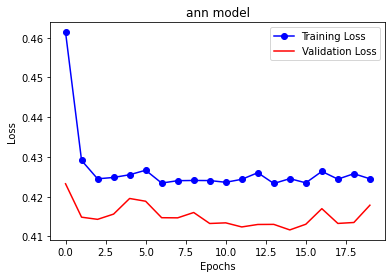

In [17]:
plot_loss(train_loss, val_loss, "ann model")

In [18]:
num_epochs = 50

net = RecNet().to(device)
criterion = MCRMSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
### train base ann
train_loss  = []
val_loss = []
for epoch in range(num_epochs):
    net.train()
    train_batch_loss = []
    for data in train_iter:
        id, x, y = data
        x = x.type(torch.FloatTensor)
        y = y.type(torch.FloatTensor)
        x = Variable(x).to(device)
        y = Variable(y).to(device)
        # ===================forward=====================
        y_hat = net(x)
        loss = criterion(y_hat, y)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        train_batch_loss.append(loss.item())
    l = np.mean(train_batch_loss)
    print("finished training epoch {}\tloss: {}".format(epoch, l))
    train_loss.append(l)

    net.eval()
    val_batch_loss  = []
    with torch.no_grad():
      for id, x, y in val_iter:
          x = x.type(torch.FloatTensor)
          y = y.type(torch.FloatTensor)
          x = Variable(x).to(device)
          y = Variable(y).to(device)
          # ===================forward=====================
          y_hat = net(x)
          loss = criterion(y_hat, y)
          val_batch_loss.append(loss.item())
    val_loss.append(np.mean(val_batch_loss))
    print("validation loss: {}".format(np.mean(val_batch_loss)))
    print()

finished training epoch 0	loss: 0.47280307188630105
validation loss: 0.38534759125619567

finished training epoch 1	loss: 0.3638548828661442
validation loss: 0.33447847009267445

finished training epoch 2	loss: 0.3318022765219212
validation loss: 0.30864369897347577

finished training epoch 3	loss: 0.31643146127462385
validation loss: 0.30060117321569213

finished training epoch 4	loss: 0.31021781265735626
validation loss: 0.28927103893936806

finished training epoch 5	loss: 0.30034341663122177
validation loss: 0.27884264613659876

finished training epoch 6	loss: 0.29496766850352285
validation loss: 0.27671646054998134

finished training epoch 7	loss: 0.2874605730175972
validation loss: 0.26857162027988796

finished training epoch 8	loss: 0.2832565799355507
validation loss: 0.2658008003853402

finished training epoch 9	loss: 0.2777519516646862
validation loss: 0.26833135025493754

finished training epoch 10	loss: 0.27476727291941644
validation loss: 0.26297170368942824

finished traini

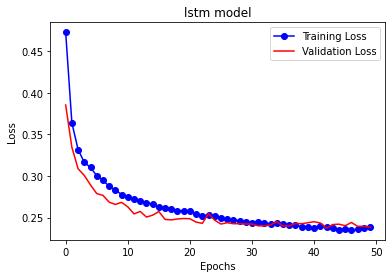

In [19]:
plot_loss(train_loss, val_loss, "lstm model")

# Generate Submission

In [ ]:
res = submission.values
net.eval()
for id, x in tqdm(test_iter):
    x = x.type(torch.FloatTensor)
    x = Variable(x).to(device)
    y_hat = net(x)    
    # y_hat.shape = [1, 130, 5]
    y_hat = y_hat[0].detach().cpu().numpy()
    assert len(y_hat) == 130 or len(y_hat) == 107
    key = "{}_{}".format(id[0], 0)
    index = np.where(submission['id_seqpos'] == key)[0][0]
    try:
      res[index: index+len(y_hat), 1:] = y_hat
    except:
      print(key)
      print(len(y_hat))
      print(index)
      print(index + len(y_hat))
        # for i in range(len(y_hat)):
        #   key = "{}_{}".format(id[0], i)
        #   index = np.where(submission['id_seqpos'] == key)[0][0]
        #   res[index, 1:] = y_hat[i]
print(res)


[['id_00073f8be_0' 0.8859161138534546 0.7243919372558594
  2.0709471702575684 0.5829291343688965 0.7883155345916748]
 ['id_00073f8be_1' 2.8602542877197266 3.1561660766601562
  4.3755950927734375 3.279874086380005 2.952470064163208]
 ['id_00073f8be_2' 1.555572509765625 0.5508415699005127
  0.8187388181686401 0.8184510469436646 0.9116118550300598]
 ...
 ['id_ffda94f24_127' 0.6355527639389038 0.2969993054866791
  0.397529661655426 0.3822692334651947 0.5306210517883301]
 ['id_ffda94f24_128' 0.2564774751663208 0.36890196800231934
  0.34237849712371826 0.45090240240097046 0.258006751537323]
 ['id_ffda94f24_129' 0.18922613561153412 0.5118383169174194
  0.8788290023803711 0.4679167866706848 0.539211630821228]]


In [ ]:
for i in range(len(res)):
    if res[i][0] != submission.loc[i, 'id_seqpos']:
      print(r)
# res = submission.values
# print(len(res))
my_sub = pd.DataFrame(res, columns=submission.columns)
my_sub.to_csv(submission_file, index=False)
my_sub.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.885916,0.724392,2.07095,0.582929,0.788316
1,id_00073f8be_1,2.86025,3.15617,4.3756,3.27987,2.95247
2,id_00073f8be_2,1.55557,0.550842,0.818739,0.818451,0.911612
3,id_00073f8be_3,1.42533,1.05404,1.24547,1.60829,1.46627
4,id_00073f8be_4,0.930697,0.606291,0.751012,0.878233,0.848565


In [ ]:
submission.head()


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0
